<a href="https://colab.research.google.com/github/yurialobao/deep-transfer-learning/blob/main/transfer_learning_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Transfer Learning for Binary Image Classification  
## A Practical and Reproducible Pipeline using MobileNetV2

This notebook demonstrates a complete and reproducible **Transfer Learning pipeline** for binary image classification tasks using TensorFlow and Keras.

The goal of this project is not limited to a specific dataset, but rather to present a structured approach that can be applied to any binary image classification problem.

The workflow includes:

1. Dataset acquisition and preparation
2. Data pipeline optimization
3. Transfer Learning (feature extraction)
4. Fine-Tuning (controlled unfreezing)
5. Automatic best-model selection
6. Final evaluation on unseen test data

The same structure can be reused for other classification problems simply by replacing the dataset directory.


In [37]:
#Install and imports project dependencies
%matplotlib inline
!pip -q install scikit-learn
!pip -q install gdown

# Standard library
import os
import random

# Third-party libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Metrics
from sklearn.metrics import confusion_matrix, classification_report

## 📂 Dataset Used in This Example

For demonstration purposes, this notebook uses a binary dataset containing images of:

- Horses
- Zebras

However, the pipeline is dataset-agnostic and works with any binary classification dataset structured as:

dataset/\
  ├── train/\
  │ ├── class_A/\
  │ └── class_B/\
  ├── val/\
  │ ├── class_A/\
  │ └── class_B/\
  └── test/\
  ├── class_A/\
  └── class_B/


The dataset is hosted publicly on Google Drive and downloaded dynamically using `gdown`, ensuring full reproducibility.

Train, validation, and test sets are separated to prevent data leakage and allow proper generalization evaluation.


In [25]:
# Module responsible for downloading and extracting the Horse and Zebra Dataset to the project Drive.

# Dataset IDs in Drive
TRAIN_ID = "1wgXoVjpLJaj6RSOIKfV3afsFO4jHbqMb"
VAL_ID   = "1hlKL7uinnsoY-Khkr_qyrTmM_UYWkNfD"
TEST_ID  = "1lDcQFJOAUlvyu4iDOWUh68Bb4s18k6sg"

# Download the files
!gdown $TRAIN_ID -O train.zip
!gdown $VAL_ID   -O val.zip
!gdown $TEST_ID  -O test.zip

# Create destination folder and extract everything into it
DEST = "/content/dataset"
os.makedirs(DEST, exist_ok=True)

!unzip -o -q train.zip -d "{DEST}"
!unzip -o -q val.zip   -d "{DEST}"
!unzip -o -q test.zip  -d "{DEST}"

# Check structure (should show train/val/test and horse/zebra)
!find "{DEST}" -maxdepth 3 -type d | sort

Downloading...
From (original): https://drive.google.com/uc?id=1wgXoVjpLJaj6RSOIKfV3afsFO4jHbqMb
From (redirected): https://drive.google.com/uc?id=1wgXoVjpLJaj6RSOIKfV3afsFO4jHbqMb&confirm=t&uuid=25b10e13-ee6c-45a9-8bce-58d5358b3f91
To: /content/train.zip
100% 138M/138M [00:01<00:00, 111MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hlKL7uinnsoY-Khkr_qyrTmM_UYWkNfD
To: /content/val.zip
100% 22.9M/22.9M [00:00<00:00, 177MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1lDcQFJOAUlvyu4iDOWUh68Bb4s18k6sg
From (redirected): https://drive.google.com/uc?id=1lDcQFJOAUlvyu4iDOWUh68Bb4s18k6sg&confirm=t&uuid=187d0ab4-bc87-4fb1-b27a-55c97b378a94
To: /content/test.zip
100% 70.5M/70.5M [00:00<00:00, 186MB/s]
/content/dataset
/content/dataset/test
/content/dataset/test/horse
/content/dataset/test/zebra
/content/dataset/train
/content/dataset/train/horse
/content/dataset/train/zebra
/content/dataset/val
/content/dataset/val/horse
/content/dataset/val/zebra


## 🔄 Data Pipeline and Preprocessing

The dataset is loaded using TensorFlow’s `image_dataset_from_directory()` utility.

Key configurations:

- Image resizing to 224x224 (required by MobileNetV2)
- Batch size = 32
- Shuffle enabled for training
- Fixed random seed for reproducibility

Performance optimizations:

- `prefetch(AUTOTUNE)` enables asynchronous loading
- Data augmentation increases generalization capacity

This pipeline can scale to larger datasets without requiring structural modifications


In [26]:
# Define dataset pipeline parameters
IMG_SIZE = (224, 224) # Define image size (all will be resized to 224x224)
BATCH = 32 # Batch size (how many images per "lot" in each step)
SEED = 42 # Seed for reproducibility (same split/order whenever possible)
tf.random.set_seed(SEED)
np.random.seed(SEED)


# Dataset paths (after extraction)
TRAIN_DIR = "/content/dataset/train"
VAL_DIR   = "/content/dataset/val"
TEST_DIR  = "/content/dataset/test"

# Create datasets from folders (each subfolder = one class)
train_ds = keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True
)

val_ds = keras.utils.image_dataset_from_directory(
    VAL_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False
)

test_ds = keras.utils.image_dataset_from_directory(
    TEST_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 1472 files belonging to 2 classes.
Found 246 files belonging to 2 classes.
Found 775 files belonging to 2 classes.
Classes: ['horse', 'zebra']


In [ ]:
# Pipeline optimizations for performance (loads next batch "in parallel")
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000, seed=SEED).prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

## 🔁 Data Augmentation Strategy

To improve robustness and reduce overfitting, on-the-fly data augmentation is applied during training:

- Random horizontal flip
- Small random rotation
- Random zoom

These transformations simulate natural variations in image data and help the model generalize better to unseen samples.


In [27]:
# Data augmentation: creates variations of the images to help the model generalize better
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.05),
    keras.layers.RandomZoom(0.1),
])


## 🧠 Transfer Learning – Feature Extraction

Instead of training a convolutional neural network from scratch, we leverage **MobileNetV2**, pre-trained on ImageNet.

Configuration:

- `include_top=False` removes the original classifier
- `weights="imagenet"` loads pre-trained weights
- The base model is frozen during the first phase

A lightweight custom classification head is added on top:

- GlobalAveragePooling2D
- Dropout (0.2)
- Dense layer with sigmoid activation

This allows the model to reuse learned visual features while adapting to a new binary classification task.


In [28]:
# Load the pre-trained MobileNetV2 on ImageNet as a feature extractor
base = keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,     # remove the "top" (ImageNet 1000-class classifier)
    weights="imagenet"     # use pre-trained weights
)

# Freeze the base (do not train these weights in phase 1)
base.trainable = False

# Define the model input
inputs = keras.Input(shape=IMG_SIZE + (3,))

# Apply data augmentation
x = data_augmentation(inputs)

# MobileNetV2-specific preprocessing (normalize the way it expects)
x = keras.applications.mobilenet_v2.preprocess_input(x)

# Pass through the pre-trained base (feature extractor)
x = base(x, training=False)

# Reduce to vector (global average of features)
x = keras.layers.GlobalAveragePooling2D()(x)

# Dropout helps prevent overfitting
x = keras.layers.Dropout(0.2)(x)

# Final layer: 1 neuron with sigmoid (binary classification)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

# Build the final model
model = keras.Model(inputs, outputs)

# Compile with Adam, binary loss, and accuracy metric
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 🚀 Training – Transfer Learning Phase

During this phase:

- The convolutional base remains frozen
- Only the classification head is trained
- EarlyStopping prevents overfitting
- ModelCheckpoint saves the best-performing weights

This evaluates how well pre-trained ImageNet features transfer to a new problem.


In [30]:
# Automatically saves the best model from the TL phase (based on val_loss)
ckpt_tl = keras.callbacks.ModelCheckpoint(
    filepath="/content/best_tl.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

# Early stopping and also restores the best weights in memory
early = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

callbacks_tl = [early, ckpt_tl]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks_tl
)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7995 - loss: 0.4275
Epoch 1: val_loss improved from inf to 0.06105, saving model to /content/best_tl.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8019 - loss: 0.4238 - val_accuracy: 0.9878 - val_loss: 0.0611
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9741 - loss: 0.0808
Epoch 2: val_loss improved from 0.06105 to 0.03727, saving model to /content/best_tl.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9744 - loss: 0.0804 - val_accuracy: 0.9878 - val_loss: 0.0373
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9880 - loss: 0.0402
Epoch 3: val_loss improved from 0.03727 to 0.02619, saving model to /content/best_tl.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9880 - loss: 0.0402 - val_accuracy: 0.9878 - val_loss: 0.0262
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9926 - loss: 0.0345
Epoch 4: val_loss did not improve from 0.02619
46/46 ━

## 🔬 Fine-Tuning Phase

In the second stage, part of the base model is unfrozen:

- The last 80 layers are set as trainable
- A smaller learning rate (1e-5) is used

Fine-tuning allows higher-level features to adjust slightly to the new dataset.

However, if the dataset is small, fine-tuning may lead to overfitting.


In [31]:
# 1) Unfreeze the base and keep most layers frozen (to avoid overfitting)
base.trainable = True
for layer in base.layers[:-80]:
    layer.trainable = False

# 2) IMPORTANT: recompile after changing trainable
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# 3) Automatically save the best fine-tuning model
ckpt_ft = keras.callbacks.ModelCheckpoint(
    filepath="/content/best_ft.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

callbacks_ft = [early, ckpt_ft]

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=callbacks_ft
)



Epoch 1/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8687 - loss: 0.2985
Epoch 1: val_loss improved from inf to 0.02281, saving model to /content/best_ft.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.8689 - loss: 0.2978 - val_accuracy: 0.9878 - val_loss: 0.0228
Epoch 2/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9487 - loss: 0.1376
Epoch 2: val_loss did not improve from 0.02281
46/46 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.9489 - loss: 0.1369 - val_accuracy: 0.9837 - val_loss: 0.0353
Epoch 3/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9837 - loss: 0.0612
Epoch 3: val_loss did not improve from 0.02281
46/46 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.9837 - loss: 0.0612 - val_accuracy: 0.9837 - val_loss: 0.0405


## 🏆 Automatic Best Model Selection

After both training phases:

- The model with the lowest validation loss is selected automatically.
- If fine-tuning improves performance, it is used.
- Otherwise, the original transfer learning model is kept.

The final selected model is saved as:

`best_model.keras`

This ensures reproducibility and avoids manual bias in model selection.


In [33]:
# Get the best validation loss from TL and FT phases
best_tl_val_loss = float(np.min(history.history["val_loss"]))
best_ft_val_loss = float(np.min(history_ft.history["val_loss"]))

# Define the path for the final best model
best_model_path = "/content/best_model.keras"

# Compare TL and FT results and choose the best model
if best_ft_val_loss < best_tl_val_loss:
    print("Fine-tuning improved. Using best_ft.keras as final.")
    model = keras.models.load_model("/content/best_ft.keras")
else:
    print("Fine-tuning did not improve. Using best_tl.keras as final.")
    model = keras.models.load_model("/content/best_tl.keras")

# Save the final chosen model
model.save(best_model_path)
print("FINAL model saved at:", best_model_path)
print(f"Best TL val_loss: {best_tl_val_loss:.6f}")
print(f"Best FT val_loss: {best_ft_val_loss:.6f}")


Fine-tuning did not improve. Using best_tl.keras as final.
FINAL model saved at: /content/best_model.keras
Best TL val_loss: 0.011375
Best FT val_loss: 0.022807


## 📊 Final Evaluation

The selected model is evaluated on a completely unseen test dataset.

Metrics reported:

- Test Loss
- Test Accuracy
- Precision
- Recall
- F1-score
- Confusion Matrix

This step measures real-world generalization performance.


In [34]:
# Load the final model automatically chosen (TL or FT)
model = keras.models.load_model("/content/best_model.keras")

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test loss: {test_loss:.6f}")
print(f"Test accuracy: {test_acc:.6f}")

Test loss: 0.025271
Test accuracy: 0.989677


              precision    recall  f1-score   support

       horse       0.99      0.99      0.99       360
       zebra       0.99      0.99      0.99       415

    accuracy                           0.99       775
   macro avg       0.99      0.99      0.99       775
weighted avg       0.99      0.99      0.99       775



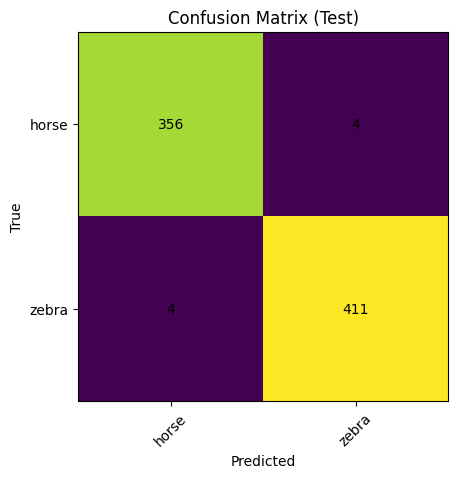

Report saved at /content/artifacts/classification_report.txt


In [39]:
# Collect y_true and y_pred
y_true, y_prob = [], []

for images, labels in test_ds:
    probs = model.predict(images, verbose=0).reshape(-1)
    y_prob.extend(probs.tolist())
    y_true.extend(labels.numpy().tolist())

y_true = np.array(y_true).astype(int)
y_pred = (np.array(y_prob) >= 0.5).astype(int)

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0,1], class_names, rotation=45)
plt.yticks([0,1], class_names)
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.savefig("/content/artifacts/confusion_matrix_test.png", bbox_inches="tight")
plt.show()

# Save report as txt (for GitHub)
os.makedirs("/content/artifacts", exist_ok=True)
with open("/content/artifacts/classification_report.txt", "w") as f:
    f.write(report)

print("Report saved at /content/artifacts/classification_report.txt")

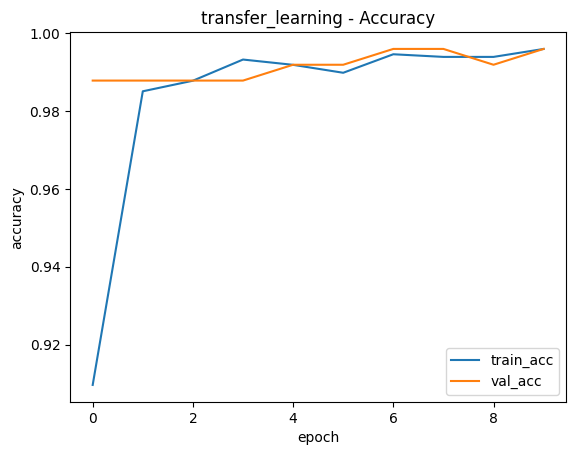

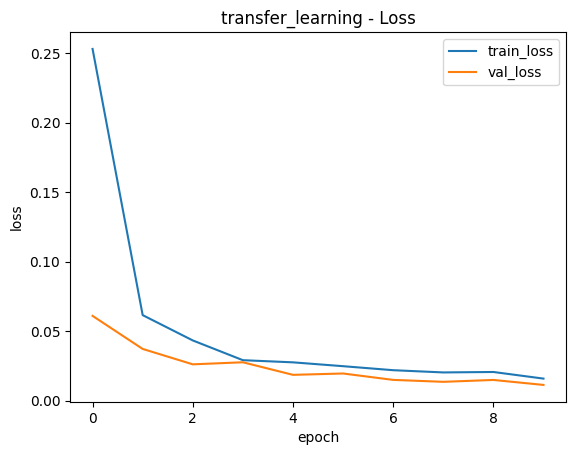

saved: /content/artifacts/transfer_learning_accuracy.png e /content/artifacts/transfer_learning_loss.png


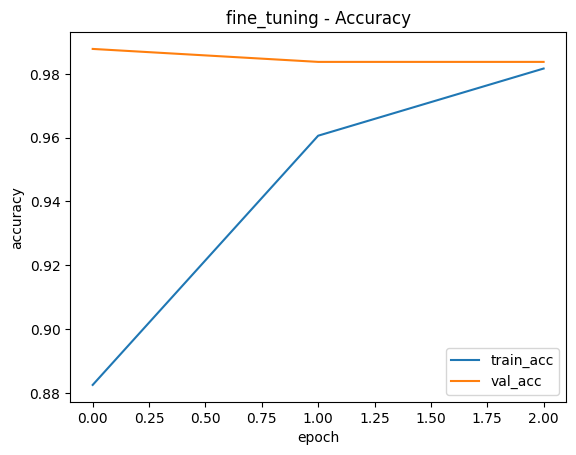

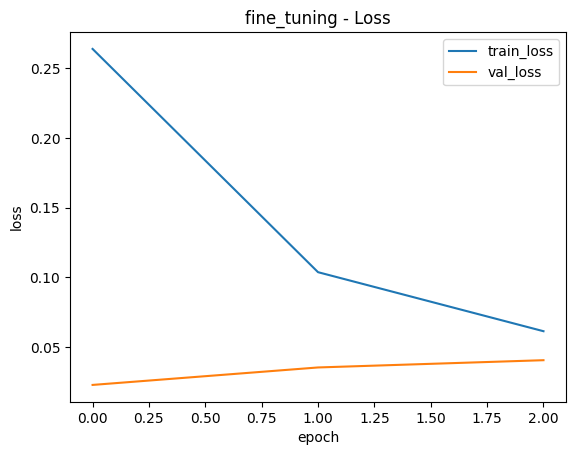

saved: /content/artifacts/fine_tuning_accuracy.png e /content/artifacts/fine_tuning_loss.png


In [38]:
os.makedirs("/content/artifacts", exist_ok=True)

def save_history_plots(hist, prefix):
    # Accuracy
    plt.figure()
    plt.plot(hist.history["accuracy"], label="train_acc")
    plt.plot(hist.history["val_accuracy"], label="val_acc")
    plt.title(f"{prefix} - Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    acc_path = f"/content/artifacts/{prefix}_accuracy.png"
    plt.savefig(acc_path, bbox_inches="tight")
    plt.show()

    # Loss
    plt.figure()
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="val_loss")
    plt.title(f"{prefix} - Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    loss_path = f"/content/artifacts/{prefix}_loss.png"
    plt.savefig(loss_path, bbox_inches="tight")
    plt.show()

    print("saved:", acc_path, "e", loss_path)

save_history_plots(history, "transfer_learning")
save_history_plots(history_ft, "fine_tuning")


## ✅ Conclusion

This notebook demonstrates a robust and reusable Transfer Learning pipeline for binary image classification.

Key takeaways:

- Pre-trained ImageNet features generalize well to new tasks.
- Fine-tuning does not always improve performance.
- Automatic model selection improves reliability.
- The pipeline is easily adaptable to other datasets.

This structure can serve as a template for future computer vision projects.

This experiment reinforces the practical effectiveness of Transfer Learning in real-world computer vision scenarios, especially when working with limited labeled data.

